# **Árvore de Regressão e Random Forest**

* Parte 1: Entendimento e divisão do dataset
* Parte 2: Aplicação do algoritmo DecisionTreeRegressor
* Parte 3: Avaliação de desempenho
* Parte 4: Aplicação do algoritmo RandomForest
* Parte 5: Avaliação de desempenho

In [32]:
#Bibliotecas necessárias, modelos e métricas do scikit-learn e outros
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import StandardScaler, MinMaxScaler, KernelCenterer,Normalizer

from sklearn.pipeline import make_pipeline

from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor

from sklearn.neural_network import MLPRegressor

from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV,\
                                    validation_curve, cross_val_score, \
                                    cross_validate, \
                                    RepeatedKFold, cross_val_predict, StratifiedKFold
from scipy.stats import uniform, randint

#Bibliotecas/funções matheus
from envcity_plot_lib import *

from alphasense_b_sensors.alphasense_sensors import *

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error

# <font color=white>**Parte 1**: Entendimento e divisão do dataset

Definição das variáveis
- no2 IAG
- no2_1 estação
- no2_2 estação
- no2_3 estação
- no2_4 estação
- no2_we (working electord)
- no2_ae (auxiliary electrodo)
- best_so

In [37]:
#Leitura da base de dados da estação grafana com os dados de CO
df_bestNO2 = pd.read_csv('best-no2.csv')
df_ae = pd.read_csv("no2_ae.csv")
df_we = pd.read_csv("no2_we.csv")
df_temp = pd.read_csv("temperatura.csv") #df da temperatura

df_temp.columns = ['time', 'temperatura']


df_bestNO2 =df_bestNO2.dropna()
df_temp.dropna(subset=['temperatura'], inplace=True)

# #Conversão do timestamp em milissegundos para datetime
df_bestNO2['time'] = pd.to_datetime(df_bestNO2['time']) 


# #padronizando time nas tabelas
df_bestNO2['time'] = pd.to_datetime(df_bestNO2['time'], unit='ms').dt.round('1s')
df_ae['time'] = pd.to_datetime(df_ae['time']).dt.round('1s')
df_we['time'] = pd.to_datetime(df_we['time']).dt.round('1s')
df_temp['time'] = pd.to_datetime(df_temp['time']).dt.round('1s')

# #Limpeza das colunas de AE e WE (remover " ppb" e converter para float)
df_bestNO2['NO2'] = df_bestNO2['NO2'].str.replace(' ppb', '', regex=False).astype(float)
df_ae['NO2_AE'] = df_ae['NO2_AE'].str.replace(' ppb', '', regex=False).astype(float)
df_we['NO2_WE'] = df_we['NO2_WE'].str.replace(' ppb', '', regex=False).astype(float)
df_temp['temperatura'] = df_temp['temperatura'].str.replace(' °C', '', regex=False) #eliminando strings

# #Mesclagem com base na coluna 'time'
df = df_bestNO2.merge(df_ae, on='time', how='inner') \
               .merge(df_we, on='time', how='inner') \
               .merge(df_temp, on= 'time', how='inner')

df
#ALPHASENSE. Designing a potentiostatic circuit. 2022. Disponível em: <https://www.alphasense.com/wp-content/uploads/2022/10/AAN\_105-03\_App-Note\_V0.pdf>.Citado na página 23

,time,NO2,NO2_AE,NO2_WE,temperatura
0,2025-03-07 13:19:00,3.29,0.00131,0.00150,29.1
1,2025-03-07 13:20:13,3.28,0.00150,0.00131,29.1
2,2025-03-07 13:21:25,3.29,0.00131,0.00150,29.1
3,2025-03-07 13:22:32,3.29,0.00131,0.00150,29.2
4,2025-03-07 13:23:38,3.28,0.00150,0.00150,29.2
...,...,...,...,...,...
321217,2025-06-16 19:45:44,3.29,0.00131,0.00150,23.9
321218,2025-06-16 19:45:44,3.29,0.00131,0.00150,23.9
321219,2025-06-16 19:45:44,3.29,0.00131,0.00150,23.9
321220,2025-06-16 19:45:44,3.29,0.00131,0.00150,23.9


In [38]:
#Leitura da base de dados da estação IAG de São Paulo
#print(aqm.shape)
#print(aqm.describe())
aqm = pd.read_csv('envcity_aqm_df.csv')
aqm.head()

,time,e1_anem,e1_anem_volt,e1_co,e1_co_2,e1_co_3,e1_co_4,e1_co_ae,e1_co_we,e1_location,...,iag_pm25,iag_pmcoarse,iag_pressure,iag_rainfalltotal,iag_sigma,iag_so2,iag_solarradiation,iag_wd,iag_ws,pin_umid
0,2023-02-15 13:41:00,12.036327,NaN,-1315.716919,459.329041,465.226715,598.345581,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-02-15 13:42:00,11.174897,NaN,-1575.367554,385.721252,395.833496,624.081055,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-02-15 13:43:00,11.703624,NaN,-3228.860352,-520.005371,-492.953430,117.647057,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-02-15 13:44:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-02-15 13:45:00,11.888990,NaN,-1663.602783,315.461090,325.980530,563.419250,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
#filtrando as linhas onde e1_co tem valores válidos
df_filtrado = aqm[aqm['e1_no2'].notna()][['time', 'e1_no2', 'iag_no2']]

#remover linhas onde iag_co é NaN
df_filtradoIAG = df_filtrado[df_filtrado['iag_no2'].notna()]

df_filtradoIAG 

,time,e1_no2,iag_no2
40939,2023-03-16 00:00:00,-0.161290,10.40
40943,2023-03-16 00:04:00,-0.040322,11.69
40947,2023-03-16 00:08:00,2.983842,11.74
40951,2023-03-16 00:12:00,-2.459657,12.36
40954,2023-03-16 00:15:00,-3.064516,9.51
...,...,...,...
134275,2023-05-19 19:36:00,11.209678,26.95
134279,2023-05-19 19:40:00,9.274194,26.86
134283,2023-05-19 19:44:00,9.516129,26.45
134287,2023-05-19 19:48:00,13.991936,27.68


In [40]:

df= df.iloc[:len(df_filtradoIAG)].copy() #iloc garante mesmo número de linhas para evitar erro.
# Adiciona a coluna 'iag_co' ao DataFrame 'df', usando os dados da coluna 'iag_co' de 'df_filtradoIAG'

df['iag_no2'] = df_filtradoIAG['iag_no2'].reset_index(drop=True) # evita que o índice antigo seja mantido, o que quebraria a correspondência entre as linhas dos DataFrames.

df = df.dropna()
df


,time,NO2,NO2_AE,NO2_WE,temperatura,iag_no2
0,2025-03-07 13:19:00,3.29,0.00131,0.00150,29.1,10.40
1,2025-03-07 13:20:13,3.28,0.00150,0.00131,29.1,11.69
2,2025-03-07 13:21:25,3.29,0.00131,0.00150,29.1,11.74
3,2025-03-07 13:22:32,3.29,0.00131,0.00150,29.2,12.36
4,2025-03-07 13:23:38,3.28,0.00150,0.00150,29.2,9.51
...,...,...,...,...,...,...
21806,2025-04-02 17:45:12,4.39,0.00131,0.34500,29.2,26.95
21807,2025-04-02 17:46:18,4.49,0.00131,0.37600,29.2,26.86
21808,2025-04-02 17:47:25,4.31,0.00131,0.32000,29.2,26.45
21809,2025-04-02 17:48:31,4.54,0.00131,0.39100,29.2,27.68


## Cálculo da concentração em ppm com coeficientes da Alphasense

In [7]:

## JA CALCULA EM PPB CABEÇA DE AUTOMATO
# labels =  ['CO_AE', 'CO_WE']

# label_ref= 'iag_co'

# co = Alphasense_Sensors("CO-B4", "162741354")

# ae = df[labels[0]]*1000
# we = df[labels[1]]*1000
# we

In [8]:
# ppb = ((we - co.electronic_we) - (ae - co.electronic_ae))/co.sensitivity

# df['CO'] = ppb / 1000


# <font color=yellow>**Parte 2**: Aplicação do algoritmo RF e DecisionTreeRegressor

In [41]:
#https://pt.stackoverflow.com/questions/428437/como-funciona-o-m%C3%A9todo-train-test-split-no-scikit-learn

#Preparo do dataset para regressão
labels =  ['NO2_AE', 'NO2_WE']
label_ref= 'iag_no2'
Yco = df[label_ref] # Y do IAG

Xco = df.loc[Yco.index][['NO2', 'NO2_AE', 'NO2_WE']] # X da estação grafana
Yco


0        10.40
1        11.69
2        11.74
3        12.36
4         9.51
         ...  
21806    26.95
21807    26.86
21808    26.45
21809    27.68
21810    26.38
Name: iag_no2, Length: 21811, dtype: float64

Split dos dados

In [42]:
X_train, X_valid, y_train, y_valid = train_test_split(Xco, Yco, train_size=0.8)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train)

Validação Cruzada Repetida

In [43]:
kfold = RepeatedKFold(n_splits = 5, n_repeats = 1)
# kfold = StratifiedKFold(n_splits = 5)

In [44]:
print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)

(13086, 3)
(4362, 3)
(4363, 3)


Otimização de hiperparametros (RF)

In [45]:
param_grid = {"randomforestregressor__n_estimators": np.array([32, 128, 512, 1024]),
              # "randomforestregressor__max_depth": None,
              #  "randomforestregressor__oob_score" : [True],
              # "randomforestregressor__bootstrap" : [False, True],
              # 'randomforestregressor__max_features': ["sqrt", "log2", None],
              'randomforestregressor__criterion': ['squared_error' ]}# 'absolute_error', 'friedman_mse']}

In [46]:
# criação do pipeline de regressao com RF
regressor = make_pipeline(RandomForestRegressor())

linReg = LinearRegression().fit(X_train, y_train)

#GridSearch com validação cruzada
gs = GridSearchCV(regressor, param_grid=param_grid, n_jobs=-1, verbose = 3,\
                  return_train_score=True, cv = kfold, error_score = 'raise')

    
res = gs.fit(X_train,y_train)


Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 4/5] END randomforestregressor__criterion=squared_error, randomforestregressor__n_estimators=32;, score=(train=0.012, test=-0.006) total time=   0.2s
[CV 3/5] END randomforestregressor__criterion=squared_error, randomforestregressor__n_estimators=32;, score=(train=0.013, test=-0.008) total time=   0.2s
[CV 5/5] END randomforestregressor__criterion=squared_error, randomforestregressor__n_estimators=32;, score=(train=0.015, test=-0.004) total time=   0.3s
[CV 2/5] END randomforestregressor__criterion=squared_error, randomforestregressor__n_estimators=32;, score=(train=0.014, test=-0.009) total time=   0.4s
[CV 1/5] END randomforestregressor__criterion=squared_error, randomforestregressor__n_estimators=32;, score=(train=0.017, test=-0.005) total time=   0.4s
[CV 1/5] END randomforestregressor__criterion=squared_error, randomforestregressor__n_estimators=128;, score=(train=0.018, test=-0.005) total time=   0.8s
[CV 4/5] END ra

Resultado otimização

   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.289518      0.070194         0.016897        0.011127   
1       0.855332      0.075995         0.041032        0.014443   
2       2.853928      0.132566         0.118501        0.005654   
3       4.393916      0.252361         0.150216        0.002000   

  param_randomforestregressor__criterion  \
0                          squared_error   
1                          squared_error   
2                          squared_error   
3                          squared_error   

   param_randomforestregressor__n_estimators  \
0                                         32   
1                                        128   
2                                        512   
3                                       1024   

                                              params  split0_test_score  \
0  {'randomforestregressor__criterion': 'squared_...          -0.005194   
1  {'randomforestregressor__criterion': 'squared_...

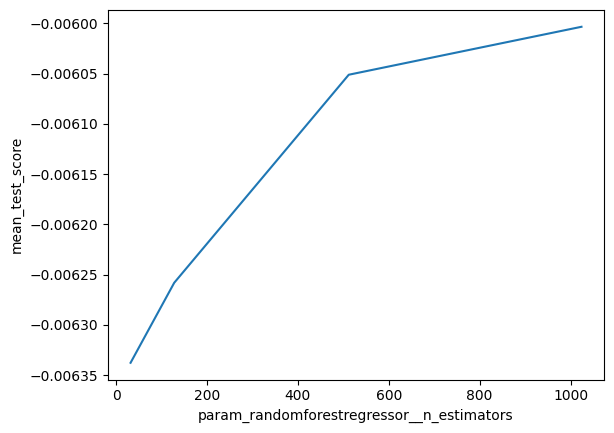

In [47]:

print(train_data := pd.DataFrame(res.cv_results_))

with open('tabela_treino.tex', 'w') as f:
    f.write(train_data.style.to_latex())
    
    
var = 'squared_error'
var2 = 'sqrt'
# mse = train_data.query("param_randomforestregressor__criterion == @var and param_randomforestregressor__max_features == @var2")
mse_df = train_data.query("param_randomforestregressor__criterion == @var")

with open('tabela_treino_mse.tex', 'w') as f:
    f.write(mse_df.style.to_latex())
    
mse_df = mse_df.sort_values('param_randomforestregressor__n_estimators', axis = 0)

# Plot the responses for different events and regions
sns.lineplot(x="param_randomforestregressor__n_estimators", y="mean_test_score",
             #hue="param_randomforestregressor__max_features", # style="event",
             data=train_data)
plt.show()


In [48]:

def mse(y, yref):
    return np.mean(np.square(np.subtract(yref, y)))

def rmse(y, yref):
    return np.sqrt(mse(y, yref))

Linear Regression Model
Train Score:  0.003089783723352668
Test Score:  0.004406037095398552
Validation Score:  0.005504173737400531
RMSE Score:  2606.0301388399366
[  59.92476923  996.45448403 -185.12861835]


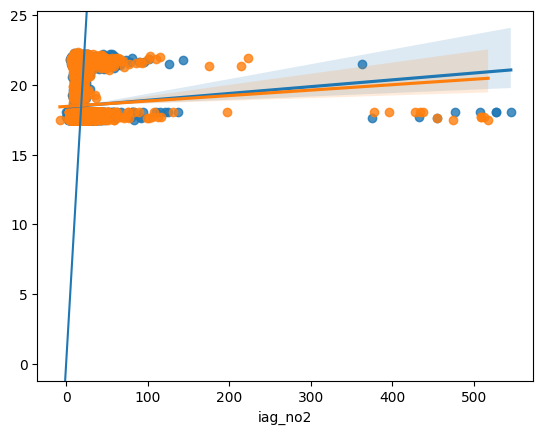

In [51]:
print("Linear Regression Model")
print("Train Score: ", linReg.score(X_train, y_train))
print("Test Score: ", linReg.score(X_test, y_test))
print("Validation Score: ", r2_score(y_valid, linReg.predict(X_valid)))
print("RMSE Score: ", 100*rmse(y_train, linReg.predict(X_train)))

print(linReg.coef_)

sns.regplot(x = y_valid, y = linReg.predict(X_valid))
sns.regplot(x = y_test, y = linReg.predict(X_test))
plt.gca().axline((0,0), slope=1)
plt.show()

In [43]:
# plt.figure(figsize=(15,5))
# plt.plot(df['Time'], df['SO2'])
# plt.title('Variação de SO2 ao longo do tempo')
# plt.xlabel('Data/Hora')
# plt.ylabel('Concentração (ppb)')
# #plt.grid()
# #plt.show()

In [28]:
#Boxplot 

# plt.figure(figsize=(10,5))
# sns.boxplot(x='day', y='SO2', data=df)
# plt.title('Distribuição de SO2 por dia')
# plt.show()

In [29]:
# #analise do horario

# plt.figure(figsize=(10,5))
# sns.lineplot(x='hour', y='SO2', data=df)
# plt.title('Variação média de SO2 por hora')
# plt.show()

In [30]:
# #compara estatitisticas descritivas entre os dias

# df.groupby('day')['SO2'].describe()

In [32]:
#variação de SO2 por dia e hora

# pivot = df.pivot_table(values='SO2', index='hour', columns='day')
# plt.figure(figsize=(10,5))
# sns.heatmap(pivot, cmap='YlOrRd')
# plt.title('Variação de SO2 por hora e dia')
# plt.show()

In [52]:
from sklearn.tree import DecisionTreeRegressor

# Criando a classe DecisionTreeRegressor()
regressor = DecisionTreeRegressor()

# Ajustando o algoritmo a base de dados
regressor.fit(X_train, y_train)

# Prevendo os resultados
y_pred = regressor.predict(X_test)

In [53]:
# Comparando os valores reais com os valores previstos
df = pd.DataFrame({'Real Values':y_test, 'Predicted Values':y_pred})
df.head()

,Real Values,Predicted Values
19669,16.28,21.048043
19175,17.07,25.118182
15535,9.53,17.125119
15162,18.52,18.164695
19976,20.62,17.130000


In [54]:
import plotly.express as px

# Plotando gráfico
fig = px.line(df, y=['Real Values', 'Predicted Values'])
#salva em HTML pois pacotes.....
fig.write_html("plot1.html")


In [50]:
#dist cumulativa

# plt.figure(figsize=(10,5))
# sns.ecdfplot(data=df, x='SO2')
# plt.title('Distribuição cumulativa de SO2')
# plt.show()

# <font color=yellow>**Parte 3**: Avaliação de desempenho

Principais métricas para avaliação de desempenho de um modelo de regressão:

* **R² (Coeficiente de Determinação)** - varia de 0 a 1 e representa a proporção da variabilidade na variável dependente que pode ser explicada pelo modelo.
* **MAE (Erro Absoluto Médio)** - avalia a precisão de um modelo prever os dados já observados, sendo a média das diferenças absolutas entre as previsões do modelo e os valores reais.
* **MSE (Erro Quadrático Médio)** - também avalia a precisão do modelo, sendo calculado a partir da média das diferenças ao quadrado entre os valores previstos e os valores reais, penalizando mais erros maiores.
* **RMSE (Raiz do Erro Quadrático Médio)** - é a raiz quadrada do MSE, tornando-se assim uma métrica mais fácil de ser interpretar, já que fica na mesma unidade que o dado original.

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Calculando R²
r2 = r2_score(y_test, y_pred)

# Calculando MAE
mae = mean_absolute_error(y_test, y_pred)

# Calculando MSE
mse = mean_squared_error(y_test, y_pred)

# Calculando RMSE
rmse = np.sqrt(mse)

print('R2:', r2)
print('MAE:', mae)
print('MSE:', mse)
print('RMSE:', rmse)

Um dos principais problemas do algoritmo da Árvore de Decisão é o **OVERFITTING**: 
- Quando na base de treino o modelo tem um bom desempenho, mas na base de teste tem um desempenho ruim
- O modelo se ajustou de forma tão precisa aos dados de treinamento que aprende o ruído aleatório dos dados, mas não generaliza bem para novos dados.



# <font color=yellow>**Parte 4**: Aplicação do algoritmo RandomForest

Parâmetros:
- n_estimators: número de árvores na floresta
- max_features: número máximo de recursos considerados para dividir um nó
- max_depth: número máximo de níveis em cada árvore de decisão
- random_state: semente usada para gerar números aleatórios durante a execução do modelo

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Criando a classe RandomForestRegressor()
rf_regressor = RandomForestRegressor(n_estimators = 300, max_features = 'sqrt', max_depth = 5, random_state = 18)

# Ajustando o algoritmo a base de dados
rf_regressor.fit(X_train, y_train)

# Prevendo os resultados
y_pred = rf_regressor.predict(X_test)

In [ ]:
# Comparando os valores reais com os valores previstos
df = pd.DataFrame({'Real Values':y_test, 'Predicted Values':y_pred})
df.head()

In [ ]:
# Plotando gráfico
fig = px.line(df, y=['Real Values', 'Predicted Values'])
fig.show()

# <font color=yellow>**Parte 5**: Avaliação de desempenho

In [ ]:
# Calculando R²
r2 = r2_score(y_test, y_pred)

# Calculando MAE
mae = mean_absolute_error(y_test, y_pred)

# Calculando MSE
mse = mean_squared_error(y_test, y_pred)

# Calculando RMSE
rmse = np.sqrt(mse)

print('R2:', r2)
print('MAE:', mae)
print('MSE:', mse)
print('RMSE:', rmse)